# Project 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

## Part 1: Gaussian quadrature

### 1.1 1D quadrature

In [3]:
def quadrature1D(a, b, Nq, g):
    # Function which performs quadrature in 1D
    # of function g over the interval [a,b] with
    # Nq quadrature points where Nq = 1, 2, 3, or 4

    # Calculating half of the interval length
    h = (b-a)/2
    
    # Setting quadrature points and weights from table (barycentric coordinates)
    if Nq == 1:
        zq = 0
        pq = 2
        I = h * (pq * g(h*zq+(a+b)/2))
    elif Nq == 2:
        zq = np.array([-np.sqrt(1/3),np.sqrt(1/3)])
        pq = np.array([1,1])
    elif Nq == 3:
        zq = np.array([-np.sqrt(3/5),0,np.sqrt(3/5)])
        pq = np.array([5/9,8/9,5/9])
    elif Nq == 4:
        zq = np.array([-np.sqrt((3+2*np.sqrt(6/5))/7),-np.sqrt((3-2*np.sqrt(6/5))/7),
                       np.sqrt((3-2*np.sqrt(6/5))/7),np.sqrt((3+2*np.sqrt(6/5))/7)])
        pq = np.array([(18-np.sqrt(30)),(18+np.sqrt(30)),(18+np.sqrt(30)),(18-np.sqrt(30))])/36
    else:
        print("Error: value of Nq is not allowed")
        
    # Calculating the approx integral I
    if Nq != 1:
        I = h * sum(pq * g(h*zq+(a+b)/2))

    return I

<IPython.core.display.Javascript object>


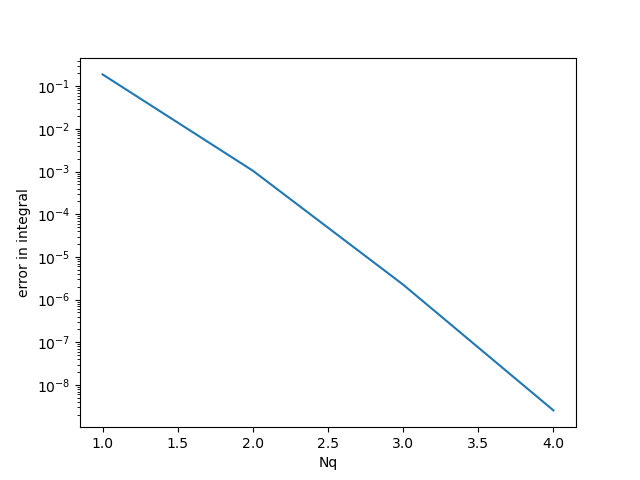

Text(0.5, 0, 'Nq')

In [4]:
test = lambda x: np.exp(x)

Nqs = [1,2,3,4]
valueI = np.zeros(len(Nqs))
actualI = np.exp(2)-np.exp(1)

for Nq in Nqs:
    valueI[Nq-1] = quadrature1D(1,2,Nq,test)
    
error = np.abs(actualI - valueI)

fig, ax = plt.subplots()
ax.semilogy(Nqs,error)
ax.set_ylabel('error in integral')
ax.set_xlabel('Nq')

#plt.savefig('1_1.pdf')

### 1.2 2D quadrature

In [5]:
def quadrature2D(p1, p2, p3, Nq, g):
    # Function which performs quadrature in 2D
    # of function g over the triangle T with verticies
    # p1, p2, and p3 with Nq quadrature points where 
    # Nq = 1, 3, or 4
    
    # Jacobian of T
    J = np.linalg.norm(np.cross(p1-p3,p2-p3))
    
    # Setting quadrature points and weights from table (barycentric coordinates)
    if Nq == 1:
        zq = np.ones(3)/3
        pq = 1
        coord = zq[0]*p1 + zq[1]*p2 + zq[2]*p3
        I = J/2 * pq * g(coord[0],coord[1])
    elif Nq == 3:
        zq = np.array([[1/2,1/2,0],[1/2,0,1/2],[0,1/2,1/2]])
        pq = np.ones(3)/3
    elif Nq == 4:
        zq = np.array([[1/3,1/3,1/3],[3/5,1/5,1/5],[1/5,3/5,1/5],[1/5,1/5,3/5]])
        pq = np.array([-9/16,25/48,25/48,25/48])
    else:
        print("Error: value of Nq is not allowed")
        
    # Calculating the coordinates in real-space and approx integral I
    if Nq != 1:
        coords = np.outer(zq[:,0],p1) + np.outer(zq[:,1],p2) + np.outer(zq[:,2],p3 )
        I = J/2 * sum(pq * g(coords[:,0],coords[:,1]))
    
    return I

<IPython.core.display.Javascript object>


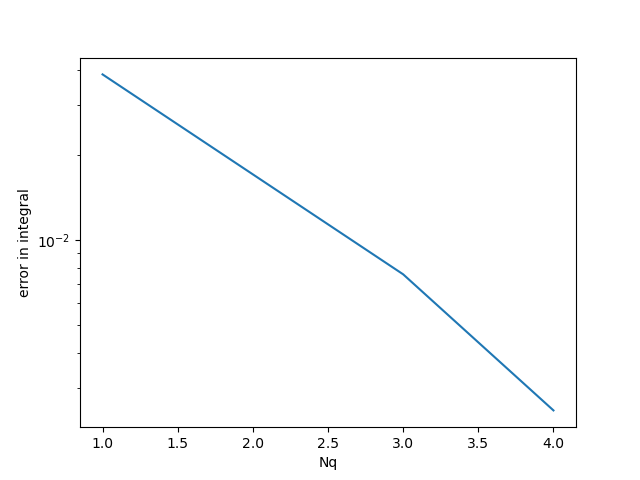

Text(0.5, 0, 'Nq')

In [6]:
test = lambda x,y: np.log(x+y)

Nqs = [1,3,4]
valueI = np.zeros(len(Nqs))
actualI = -3/2-32*np.log(2)/3+25*np.log(5)/4

for i in range(len(Nqs)):
    valueI[i] = quadrature2D(np.array([1,0]), np.array([3,1]), np.array([3,2]), Nqs[i], test)
    
error = np.abs(actualI - valueI)

fig, ax = plt.subplots()
ax.semilogy(Nqs,error)
ax.set_ylabel('error in integral')
ax.set_xlabel('Nq')
#plt.savefig('1_2.pdf')

## Part 2: Poisson in 2 dimensions

### 2.4 Implementation

In [7]:
from getdisc import GetDisc, NodalPoints, FreeBoundary, CircleData

<IPython.core.display.Javascript object>


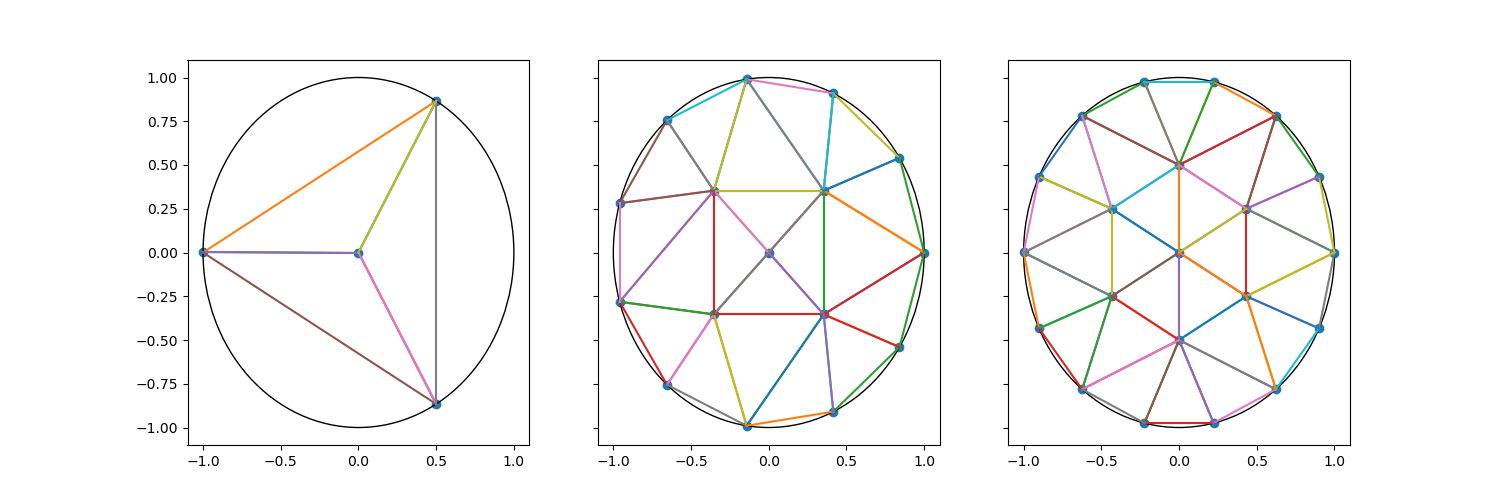

In [8]:
sizes = [4,16,21]

fig, ax = plt.subplots(1,3,sharey = True,figsize=(15, 5)) 

for i in range(len(sizes)):
    circle = plt.Circle((0, 0), 1, fill=False)
    ax[i].add_patch(circle)
    
    p,elements,edges = GetDisc(sizes[i])
    ax[i].scatter(p[:,0],p[:,1])
    
    # Plot of the lines in the triangulation
    for j in range(len(elements)):
        ax[i].plot([p[elements[j,0],0],p[elements[j,1],0]],[p[elements[j,0],1],p[elements[j,1],1]])
        ax[i].plot([p[elements[j,2],0],p[elements[j,1],0]],[p[elements[j,2],1],p[elements[j,1],1]])
        ax[i].plot([p[elements[j,0],0],p[elements[j,2],0]],[p[elements[j,0],1],p[elements[j,2],1]])
        
#plt.savefig('2_4.pdf')

### 2.5 Stiffness matrix

In [9]:
def StiffnessMatrix(N):
    # Function which creates the stiffness matrix
    # for a triangulation with N nodes
    
    # Creates function g = 1 to use quadrature to 
    # find the area of the triangles
    g = lambda x,y: 1
    
    # Get the triangulation
    p,tri,edge = GetDisc(N)
    
    A = np.zeros((N,N))
    
    # Loop over the elements to build A
    for k in range(len(tri)):
        area = quadrature2D(p[tri[k,0]], p[tri[k,1]], p[tri[k,2]], 3, g)
        
        # Find coefficients of the basis functions in element k
        C = np.linalg.solve([[1,p[tri[k,0],0],p[tri[k,0],1]],
                             [1,p[tri[k,1],0],p[tri[k,1],1]],
                             [1,p[tri[k,2],0],p[tri[k,2],1]]],
                            np.identity(3))
        
        for alpha in range(3):
            i = tri[k,alpha]
            for beta in range(3):
                j = tri[k,beta]
                A[i,j] = A[i,j] + area * (C[1,alpha] * C[1,beta] + C[2,alpha] * C[2,beta])
    return A

In [10]:
for N in [10,100,1000]:
    A = StiffnessMatrix(N)
    print('Number of nodes: ' + str(N))
    print('Rank of matrix A: ' + str(np.linalg.matrix_rank(A)))
    print('')

Number of nodes: 10
Rank of matrix A: 9

Number of nodes: 100
Rank of matrix A: 99

Number of nodes: 1000
Rank of matrix A: 999



### 2.6 Right hand side

In [11]:
def LoadVector(N, f):
    # N is number of nodes in the triangulation
    # f is the right hand side
    
    p,tri,edge = GetDisc(N)
    
    #Solution storrage
    F = np.zeros(N)
    
    # Loop over all elements
    for k in range(len(tri)): 
        
        #Finds the coefficients of the basis functions for the current element
        C = np.linalg.solve([[1,p[tri[k,0],0],p[tri[k,0],1]],
                             [1,p[tri[k,1],0],p[tri[k,1],1]],
                             [1,p[tri[k,2],0],p[tri[k,2],1]]],
                            np.identity(3))
        # Loop over the corners of the current triangle
        for alpha in range(3):
            i = tri[k, alpha] #Lokal to global map
            
            #Makes the basis function
            def H_ak(x,y): 
                return C[0,alpha] + C[1,alpha]*x + C[2,alpha]*y
            
            #Makes the function inside the integral
            def fH_ak(x,y):
                return f(x,y)*H_ak(x,y)
            
            g = lambda x,y: fH_ak(x,y)
            
            #Fill inn the vector by solving the integral with quadrature.
            F[i] = F[i] + quadrature2D(p[tri[k,0]], p[tri[k,1]], p[tri[k,2]], 3, g)
    return F

In [12]:
#Right hand side in the model problem
def f(x,y):
    return -8*np.pi*np.cos(2*np.pi*(x**2+y**2)) + 16*np.pi**2*(x**2 + y**2)*np.sin(2*np.pi*(x**2 + y**2))

#Exact solution of the model problem
def u_ex(x,y):
    return np.sin(2*np.pi*(x**2 + y**2))

### 2.7 Boundary conditions

In [13]:
#We solve the system with boundary conditions directly

def Laplace2Dsolver(N, f):
    
    #Makes the matrix without considering the boundary
    Atilde =  StiffnessMatrix(N)
    
    #Makes the right hand side without considering the boundary
    Ftilde = LoadVector(N, f)
    
    p,tri,edge = GetDisc(N)
    
    #Define the size the reduced system will have, N - #boundary-nodes
    intN = N - np.size(edge,0)
    
    #Slice the matrix to impose the boundary
    A = Atilde[:intN, :intN]
    
    #Slice the F-vector to be correct size
    F = Ftilde[:intN]
    
    #Solve the system
    u = np.linalg.solve(A,F)
    
    return u

### 2.8 Verification

<IPython.core.display.Javascript object>


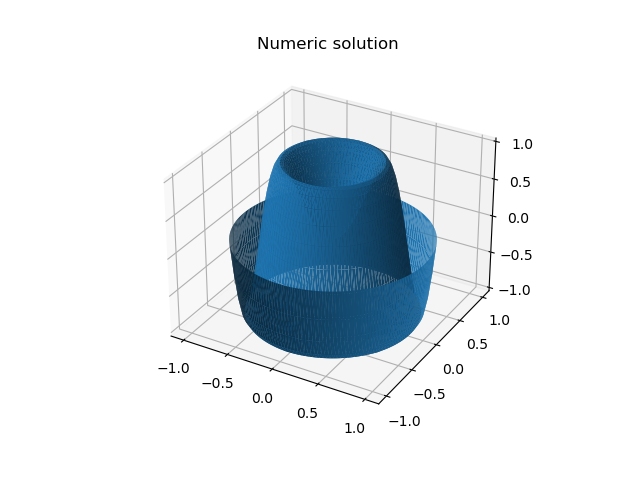

<IPython.core.display.Javascript object>


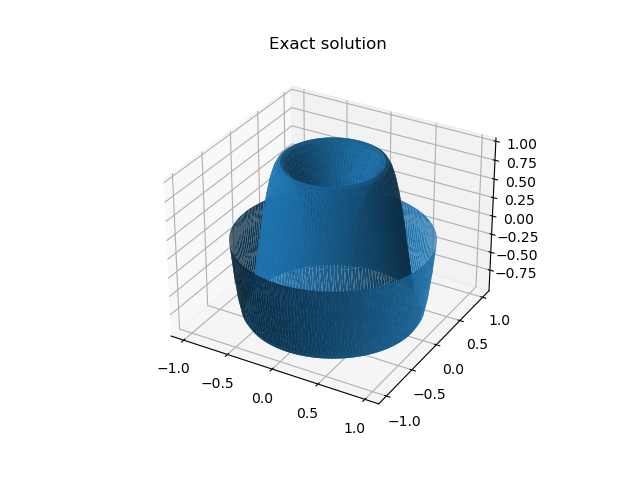

<IPython.core.display.Javascript object>


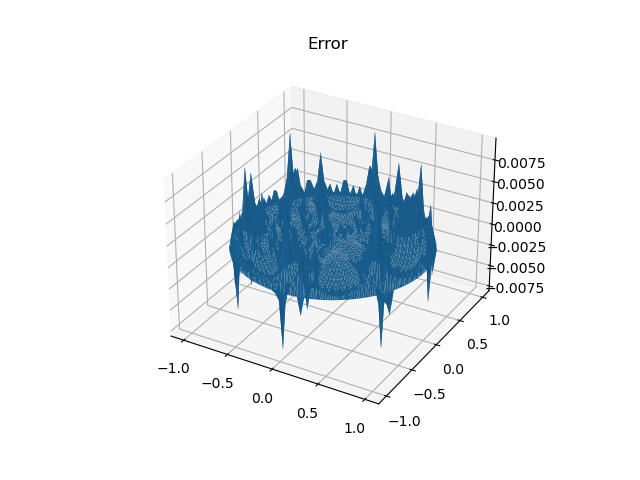

Text(0.5, 0.92, 'Error')

In [14]:
N = 3000

p,tri,edge = GetDisc(N)
u = Laplace2Dsolver(N, f)
u_w_boundary = np.zeros(len(p))
u_w_boundary[:len(u)] = u
    
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_trisurf(p[:,0],p[:,1],u_w_boundary)
ax.set_title('Numeric solution')
#fig.savefig('2_8_numeric.pdf')

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_trisurf(p[:,0],p[:,1],u_ex(p[:,0],p[:,1]))
ax.set_title('Exact solution')
#fig.savefig('2_8_exact.pdf')

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_trisurf(p[:,0],p[:,1],u_ex(p[:,0],p[:,1])-u_w_boundary)
ax.set_title('Error')
#fig.savefig('2_8_error.pdf')

<IPython.core.display.Javascript object>


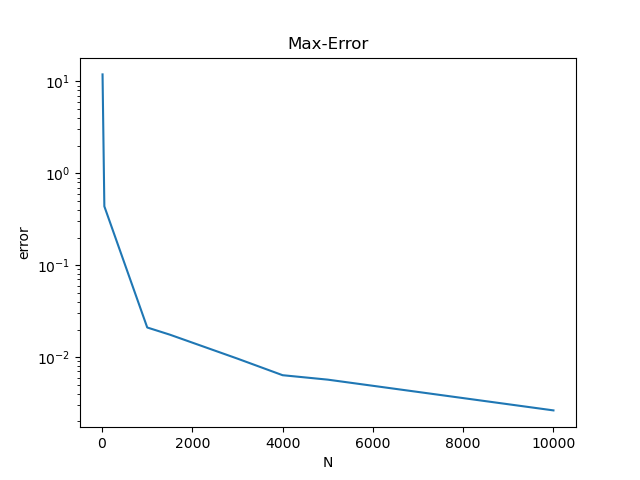

Text(0.5, 1.0, 'Max-Error')

In [15]:
N = [11,51,1001,1501,3000, 4000, 5000,10000]

error = np.zeros(len(N))

for i in range(len(N)):
    p,tri,edge = GetDisc(N[i])
    u = Laplace2Dsolver(N[i], f)
    error[i] = np.max(np.abs(u-u_ex(p[:len(u),0],p[:len(u),1])))
error

fig, ax = plt.subplots()
ax.semilogy(N,error)
ax.set_xlabel('N')
ax.set_ylabel('error')
ax.set_title('Max-Error')
#fig.savefig('2_8_maxerror.pdf')

<IPython.core.display.Javascript object>


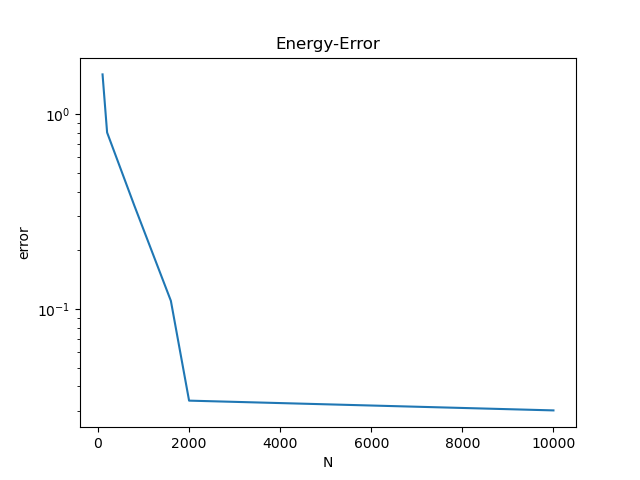

Text(0.5, 1.0, 'Energy-Error')

In [16]:
N = [100, 200, 800, 1600, 2000,10000]
error = np.zeros(len(N))

for i in range(len(N)):
    p,tri,edge = GetDisc(N[i])
    intN = N[i] - np.size(edge,0)
    
    u = Laplace2Dsolver(N[i], f)
    
    uExact = u_ex(p[:,[0]],p[:,[1]])

    uExact = uExact[:intN]
    
    e = np.zeros(intN)
    for j in range(len(uExact)):
        e[j] = (uExact[j] - u[j])
    
    Atilde = StiffnessMatrix(N[i])
    
    A = Atilde[:intN, :intN]
   
    error1 = np.linalg.solve(A,e)
    error2 = np.dot(e, error1)
    error[i] = error2
    
fig, ax = plt.subplots()
ax.semilogy(N,error)
ax.set_xlabel('N')
ax.set_ylabel('error')
ax.set_title('Energy-Error')
#fig.savefig('2_8_energierror.pdf')

## Part 3: Neumann boundary conditions

###  3.3 Gauss quadrature

In [17]:
def linequadrature2D(a,b,Nq,g):
    #Takes two points a and b in 2D, Nq which is the number of interpolation points, and a function g. 
    #Returns the straight-line integral from a to b of g. 
    
    #These quanteties are discribed in the report. 
    norm = (1/2)*np.sqrt((b[0]-a[0])**2+(b[1]-a[1])**2)
    
    def x(t): 
        return (1/2)*((1-t)*a[0] + (t+1)*b[0])
    def y(t): 
        return (1/2)*((1-t)*a[1] + (t+1)*b[1])
    def f(t):
        return g(x(t), y(t))
    
    u = lambda t: f(t) 
    
    return norm*quadrature1D(-1, 1, Nq, u)

<IPython.core.display.Javascript object>


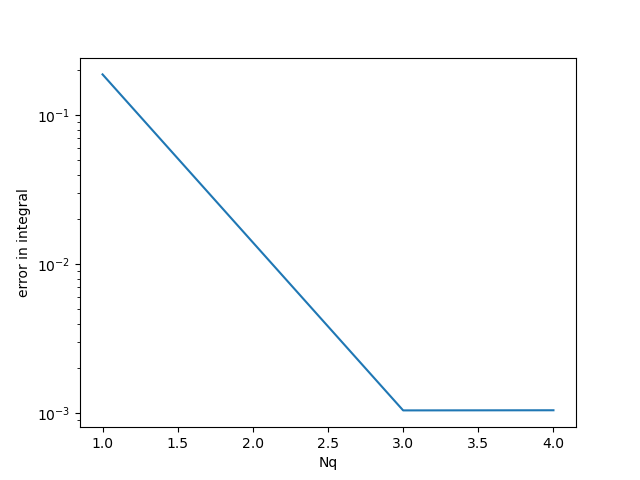

In [25]:
#Check that we get the correct value for the function described in the project.

def test3(x):
    return np.exp(x)
def test2(u,v):
    return np.exp(u)

Nqs = [1,3,4]
valueI = np.zeros(len(Nqs))
actualI = quadrature1D(1,2,2,test3)

for i in range(len(Nqs)):
    valueI[i] = linequadrature2D(np.array([1,0]), np.array([2,0]), Nqs[i], test2)
    
error = np.abs(actualI - valueI)

fig, ax = plt.subplots()
ax.semilogy(Nqs,error)
ax.set_ylabel('error in integral')
ax.set_xlabel('Nq')

fig.savefig('3_3.pdf')

In [19]:
def g(x,y):
    return 4*np.pi*np.sqrt(x**2+y**2)*np.cos(2*np.pi*(x**2+y**2)) 

In [20]:
def LoadVectorNeumann(N, f, g):
    
    p,tri,edge = GetDisc(N)
    
    F = np.zeros(N)
    
    Nboundary = []
    for i in range(N):
        if i in edge[:,0] and p[i,1] >= 0:
            Nboundary.append(i) 
    
    for k in range(len(tri)):
        C = np.linalg.solve([[1,p[tri[k,0],0],p[tri[k,0],1]],
                             [1,p[tri[k,1],0],p[tri[k,1],1]],
                             [1,p[tri[k,2],0],p[tri[k,2],1]]],
                            np.identity(3))
        for alpha in range(3):
            i = tri[k, alpha]
            
            def H_ak(x,y):
                return C[0,alpha] + C[1,alpha]*x + C[2,alpha]*y
            def fH_ak(x,y):
                return f(x,y)*H_ak(x,y)  
            
            if i in Nboundary:
                nodes = []
                for j in range(3):
                    if tri[k,j] in Nboundary:
                        nodes.append(tri[k,j])
                if len(nodes) == 2:
                    def gH_ak(x,y):
                        return g(x,y)*H_ak(x,y)
                    nodes.sort()
                    F[i] = F[i] + linequadrature2D(p[nodes[0],:],p[nodes[1],:],4,gH_ak)
            
            
            h = lambda x,y: fH_ak(x,y)
            
            F[i] = F[i] + quadrature2D(p[tri[k,0]], p[tri[k,1]], p[tri[k,2]], 3, h)
    return F   

In [28]:
def Laplace2DsolverNeumann(N, f, g):
    Atilde =  StiffnessMatrix(N)
    Ftilde = LoadVectorNeumann(N, f, g)
    
    p,tri,edge = GetDisc(N)
    
    Dboundary = []
    for i in range(N):
        if i in edge[:,0] and p[i,1] < 0:
            Dboundary.append(i)
    Nend = N - len(Dboundary)
    
    A = Atilde[:Nend, :Nend]
    F = Ftilde[:Nend]
    
    u = np.linalg.solve(A,F)
    
    return u

<IPython.core.display.Javascript object>


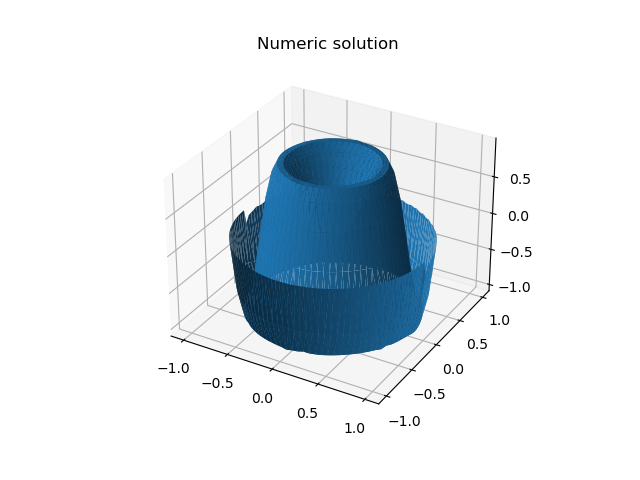

<IPython.core.display.Javascript object>


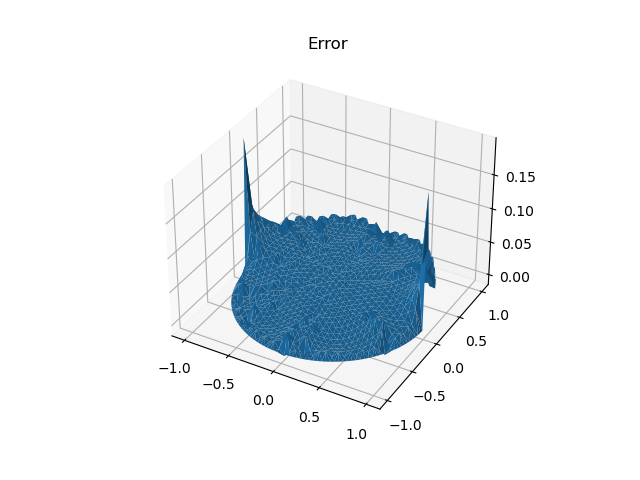

Text(0.5, 0.92, 'Error')

In [29]:
N = 1001

p,tri,edge = GetDisc(N)
u = Laplace2DsolverNeumann(N, f, g)
u_w_boundary = np.zeros(len(p))
u_w_boundary[:len(u)] = u  
    
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#ax.plot_trisurf(p[:len(u),0],p[:len(u),1],u)
ax.plot_trisurf(p[:,0],p[:,1],u_w_boundary)
ax.set_title('Numeric solution')

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_trisurf(p[:,0],p[:,1],u_ex(p[:,0],p[:,1])-u_w_boundary)
ax.set_title('Error')